In [1]:
import pandas as pd
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.calibration import calibration_curve

pd.set_option('display.max_columns', None)

# Mapping

In [2]:
data = pd.read_parquet("C:/Users/Alexxx/work/zyplai/sa_quara/data/purchase_anonim_files.parquet")
print(data.shape)
data

(32805, 16)


,new_disb_date,age,simah_score,ce_sector,income,dbr_ofo_amt,cc_gender,ca_residential_status,requested_loan_amount,basic_wage,housing_allowance,svr_jdg_count,svr_defaultamount,dbr_mal_bmo,days_in_stage,target
0,2024-01-01,40,532,nonsaudi_privt,16500.0,3441.00,m,with_the_parent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2024-01-01,27,662,privt,7075.0,2872.79,m,with_the_parent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2024-01-01,49,604,nonsaudi_privt,10000.0,1713.06,m,with_the_parent,26100.0,10000.000000,0.0,0.0,0.00,0.0,184.0,1
3,2024-01-01,40,358,nonsaudi_privt,8000.0,2450.00,m,with_the_parent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2024-01-01,24,639,privt,4512.0,727.00,f,with_the_parent,1500.0,4500.000000,500.0,0.0,0.00,0.0,699.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32800,2025-04-30,20,662,gov_military,8291.0,1854.46,m,with_the_parent,6300.0,3350.000000,NaN,0.0,0.00,0.0,444.0,0
32801,2025-04-30,32,661,privt,3990.0,670.43,f,with_the_parent,5300.0,3200.000000,800.0,0.0,0.00,0.0,867.0,0
32802,2025-04-30,22,635,privt,3590.0,217.00,m,with_the_parent,9500.0,3600.000000,400.0,0.0,0.00,0.0,211.0,0
32803,2025-04-30,36,610,privt,3590.0,0.00,m,with_the_parent,5250.0,4000.000000,0.0,0.0,525.27,43.0,1305.0,0


In [3]:
data = data.rename(columns={'ce_sector': 'sector', 'cc_gender':'Gender'})

data = data[~data['sector'].isin(['private_saudis', 'government_semi_government_saudis'])]

sector_mapping = {
    'nonsaudi_gov_nonmilitary': 'NONSAUDI_GOV-NONMILITARY',
    'nonsaudi_privt': 'NONSAUDI_PRIVT',
    'privt': 'PRIVT',
    'gov_nonmilitary': 'GOV-NONMILITARY',
    'gov_military': 'GOV-MILITARY',
    'retmt': 'RETMT',
    'private_saudis': 'NULL',  # not listed in SECTOR, mapped to NULL
    'government_semi_government_saudis': 'NULL'  # same here
}

data['sector'] = data['sector'].map(sector_mapping).fillna('NULL')
data.Gender = data.Gender.str.upper()
data = data.dropna(subset=['requested_loan_amount'])

feature_list = [
        "age",
        "simah_score",
        "sector",
        "income",
        "dbr_ofo_amt",
        "Gender",
        "requested_loan_amount",
        "basic_wage",
        "housing_allowance",
        "svr_jdg_count",
        "svr_defaultamount",
        "dbr_mal_bmo",
        "days_in_stage"
    ]

cat_feature_list = ['sector', 'Gender']

print(data.duplicated(subset=data.drop(['new_disb_date'],axis=1).columns).sum())
print(data.shape)
data[feature_list].head(4)

1
(32767, 16)


,age,simah_score,sector,income,dbr_ofo_amt,Gender,requested_loan_amount,basic_wage,housing_allowance,svr_jdg_count,svr_defaultamount,dbr_mal_bmo,days_in_stage
2,49,604,NONSAUDI_PRIVT,10000.0,1713.06,M,26100.0,10000.0,0.0,0.0,0.0,0.0,184.0
4,24,639,PRIVT,4512.0,727.00,F,1500.0,4500.0,500.0,0.0,0.0,0.0,699.0
5,39,603,GOV-NONMILITARY,6715.0,2247.99,F,6900.0,6830.0,NaN,0.0,0.0,0.0,7254.0
6,31,490,GOV-MILITARY,10030.0,4204.00,M,6040.0,4290.0,NaN,0.0,0.0,0.0,2204.0


# Modeling

In [4]:
data_for_modeling = data.copy()

default_rate = data_for_modeling['target'].mean()
print(f"Default Rate: {default_rate*100:.2f}%")

X = data_for_modeling[feature_list]
y = data_for_modeling['target']

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train = X_train_full
X_test = X_test_full

Default Rate: 13.56%



--- AUC Results ---
Train AUC: 0.8438
Test AUC: 0.8080
-------------------

--- CatBoost Native Feature Importance (Prettified Output) ---


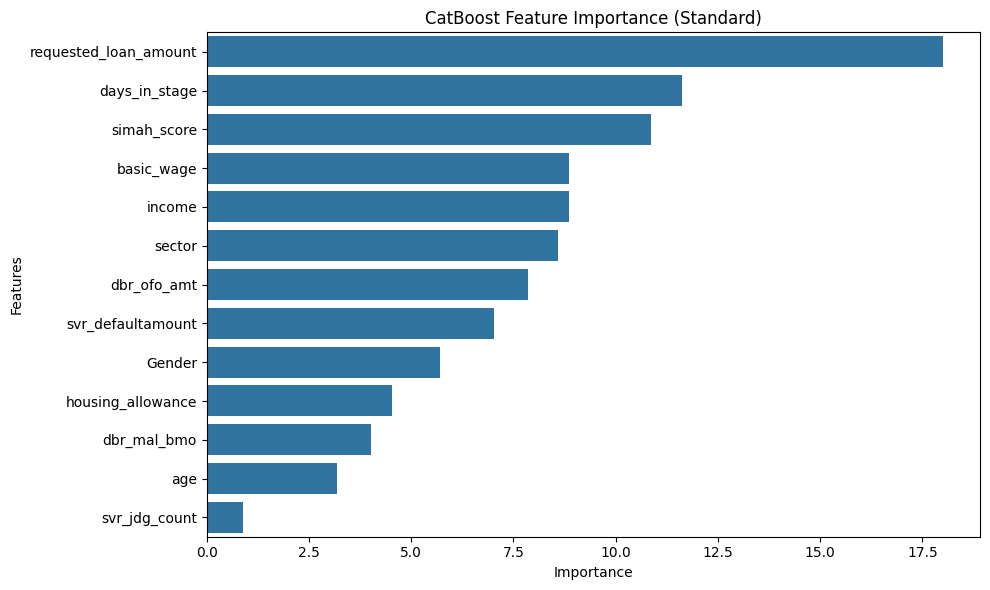



--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---


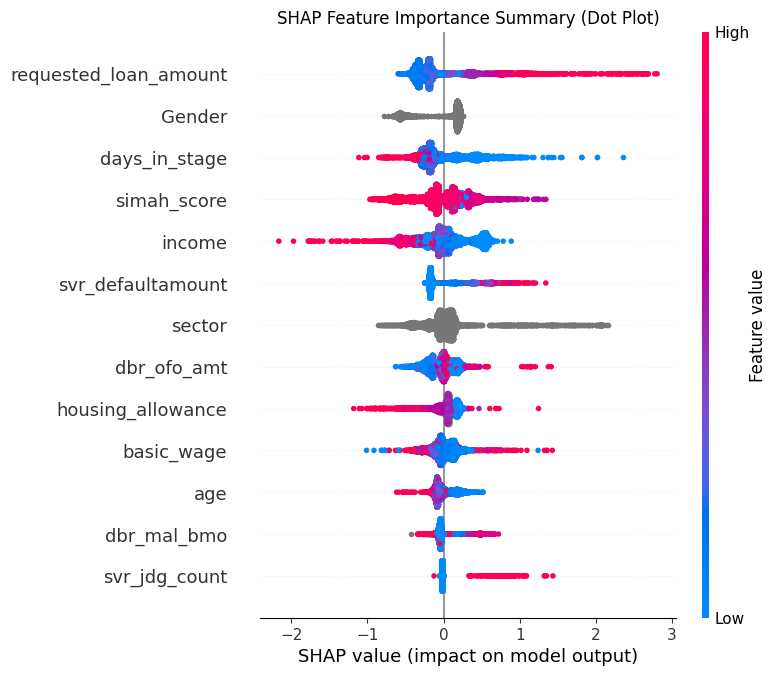

In [5]:
params = {
    'bootstrap_type': 'MVS',
    'boosting_type': 'Plain',
    'depth': 3,
    'n_estimators': 731,
    'l2_leaf_reg': 3.1544278899357883,
    'learning_rate': 0.11609595695785264,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False,
}

model = CatBoostClassifier(**params)

model.fit(
    X_train, y_train,
    cat_features=cat_feature_list,
    eval_set=(X_test, y_test)
)

y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n--- AUC Results ---")
print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")
print("-------------------")

import matplotlib.pyplot as plt
import shap
import numpy as np
import seaborn as sns
from catboost import Pool

print("\n--- CatBoost Native Feature Importance (Prettified Output) ---")

feature_importance = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_feature_list))
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.title('CatBoost Feature Importance (Standard)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print("")

print("\n--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---")

try:
    shap.initjs()
except:
    pass

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance Summary (Dot Plot)")
plt.show()
print("")

In [6]:
df = data_for_modeling.copy()

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, confusion_matrix, f1_score
)

def get_performance_metric(df: pd.DataFrame):
    train_set = df[df['is_train'] == 1].copy()
    test_set = df[df['is_train'] == 0].copy()
    target = 'target'

    model_threshold_list = []

    general_info = {
        'Samples': train_set.shape[0] + test_set.shape[0],
        'Train size': train_set.shape[0],
        'Test size': test_set.shape[0],
        'Total good': train_set[target].value_counts()[0] + test_set[target].value_counts()[0],
        'Total bad': train_set[target].value_counts()[1] + test_set[target].value_counts()[1],
        'Train good': train_set[target].value_counts()[0],
        'Train bad': train_set[target].value_counts()[1],
        'Test good': test_set[target].value_counts()[0],
        'Test bad': test_set[target].value_counts()[1],
        'Train NPL': round(train_set[target].value_counts()[1] / train_set.shape[0], 4),
        'Test NPL': round(test_set[target].value_counts()[1] / test_set.shape[0], 4),
    }

    model_performance = {
        'Train ROC AUC': round(roc_auc_score(train_set[target], train_set['prediction']), 3),
        'Test ROC AUC': round(roc_auc_score(test_set[target], test_set['prediction']), 3),
        'Train Gini': round(2 * roc_auc_score(train_set[target], train_set['prediction']) - 1, 4),
        'Test Gini': round(2 * roc_auc_score(test_set[target], test_set['prediction']) - 1, 3),
        'Train PR AUC': round(average_precision_score(train_set[target], train_set['prediction']), 3),
        'Test PR AUC': round(average_precision_score(test_set[target], test_set['prediction']), 3),
    }

    for thres in [x / 100 for x in range(5, 31, 5)]:
        thres_metrics = dict()
        test_set['prediction_label'] = (test_set['prediction'] > thres).astype(int)

        thres_metrics['Threshold'] = thres
        thres_metrics['Accuracy'] = round(accuracy_score(test_set[target], test_set['prediction_label']), 3)

        tn, fp, fn, tp = confusion_matrix(test_set[target], test_set['prediction_label']).ravel()
        thres_metrics['Model NPL'] = round(fn / (tn + fn), 3)
        thres_metrics['Approval rate'] = round((fn + tn) / (tn + fp + fn + tp), 3)
        thres_metrics['Good found'] = round(tn / (fp + tn), 3)
        thres_metrics['Bad found'] = round(tp / (fn + tp), 3)

        model_threshold_list.append(thres_metrics)

    threshold_df = pd.DataFrame(model_threshold_list)
    display(threshold_df)
    display(pd.DataFrame([general_info]))
    display(pd.DataFrame([model_performance]))
    return threshold_df, general_info, model_performance

train_pred_proba = model.predict_proba(X_train)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

preds = pd.DataFrame({
    'prediction': np.concatenate([train_pred_proba, test_pred_proba]),
    'target': np.concatenate([y_train, y_test]),
    'is_train': np.concatenate([np.ones(len(y_train)), np.zeros(len(y_test))])
})
print('123')
threshold_df, general_info, model_performance = get_performance_metric(preds)
print(get_performance_metric(preds))

123


,Threshold,Accuracy,Model NPL,Approval rate,Good found,Bad found
0,0.05,0.455,0.028,0.339,0.380,0.929
1,0.10,0.665,0.048,0.585,0.645,0.793
2,0.15,0.767,0.061,0.718,0.781,0.680
3,0.20,0.818,0.072,0.798,0.857,0.575
4,0.25,0.847,0.082,0.850,0.904,0.488
5,0.30,0.862,0.090,0.887,0.933,0.409


,Samples,Train size,Test size,Total good,Total bad,Train good,Train bad,Test good,Test bad,Train NPL,Test NPL
0,32767,24575,8192,28324,4443,21243,3332,7081,1111,0.1356,0.1356


,Train ROC AUC,Test ROC AUC,Train Gini,Test Gini,Train PR AUC,Test PR AUC
0,0.844,0.808,0.6876,0.616,0.564,0.488


,Threshold,Accuracy,Model NPL,Approval rate,Good found,Bad found
0,0.05,0.455,0.028,0.339,0.380,0.929
1,0.10,0.665,0.048,0.585,0.645,0.793
2,0.15,0.767,0.061,0.718,0.781,0.680
3,0.20,0.818,0.072,0.798,0.857,0.575
4,0.25,0.847,0.082,0.850,0.904,0.488
5,0.30,0.862,0.090,0.887,0.933,0.409


,Samples,Train size,Test size,Total good,Total bad,Train good,Train bad,Test good,Test bad,Train NPL,Test NPL
0,32767,24575,8192,28324,4443,21243,3332,7081,1111,0.1356,0.1356


,Train ROC AUC,Test ROC AUC,Train Gini,Test Gini,Train PR AUC,Test PR AUC
0,0.844,0.808,0.6876,0.616,0.564,0.488


(   Threshold  Accuracy  Model NPL  Approval rate  Good found  Bad found
0       0.05     0.455      0.028          0.339       0.380      0.929
1       0.10     0.665      0.048          0.585       0.645      0.793
2       0.15     0.767      0.061          0.718       0.781      0.680
3       0.20     0.818      0.072          0.798       0.857      0.575
4       0.25     0.847      0.082          0.850       0.904      0.488
5       0.30     0.862      0.090          0.887       0.933      0.409, {'Samples': 32767, 'Train size': 24575, 'Test size': 8192, 'Total good': 28324, 'Total bad': 4443, 'Train good': 21243, 'Train bad': 3332, 'Test good': 7081, 'Test bad': 1111, 'Train NPL': 0.1356, 'Test NPL': 0.1356}, {'Train ROC AUC': 0.844, 'Test ROC AUC': 0.808, 'Train Gini': 0.6876, 'Test Gini': 0.616, 'Train PR AUC': 0.564, 'Test PR AUC': 0.488})


In [7]:
X_test['model_pred'] = model.predict_proba(X_test[model.feature_names_])[:, 1]

X_test.sample(100, random_state=42).to_excel("../data/purchase_sample100_v3.xlsx", index=False)

In [8]:
import joblib
import json
import pickle

X_test['model_pred'] = model.predict_proba(X_test[model.feature_names_])[:, 1]

X_test.sample(10, random_state=42).to_excel("../data/purchase_sample10_v3.xlsx", index=False)

explainer = shap.TreeExplainer(model)
joblib.dump(explainer, filename='../data/purchase_explainer_v3.bz2', compress=("bz2", 9))

validator = {"title":"purchase", "type":"object", "properties":{}, "required":[]}

for col in data_for_modeling[model.feature_names_]:
    col_dtype = str(data_for_modeling[col].dtype)
    if col in cat_feature_list:
        choices = {
            "enum": [str(x) if isinstance(x, np.integer) else x for x in data_for_modeling[col].unique()],
            "type": "string"
        }
        validator["properties"][col] = choices
    elif col_dtype == "int64" or col_dtype == "float64":
        validator["properties"][col] = {
            "type": "number",
            "minimum": None,
            "maximum": None,
        }
    else:
        raise ValueError(f"Validator failed to generate, failed on column: {col}, {col_dtype}")

    validator["required"].append(col)

with open(f"../data/purchase_validator_v2.json", "w") as file:
    file.write(json.dumps(validator, indent=4))

filename = '../data/purchase_model_v3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [9]:
import json
from enum import Enum

with open("../data/purchase_validator_v2.json", "r", encoding="utf-8") as f:
    schema = json.load(f)

def to_pascal_case_two_letters(snake_str):
    parts = snake_str.split('_')
    pascal = ''.join([p.capitalize() for p in parts])
    if len(pascal) >= 2:
        return pascal[:2].upper() + pascal[2:]
    return pascal.upper()

def sanitize_enum_member(value):
    if value[0].isdigit():
        return f"_{value}"
    return value.lower()

def generate_enums_from_schema(schema):
    enums_code = []
    properties = schema.get("properties", {})
    for field_name, field_info in properties.items():
        if "enum" in field_info:
            class_name = to_pascal_case_two_letters(field_name)
            values = field_info["enum"]
            enum_members = "\n    ".join([f'{sanitize_enum_member(v)} = "{v}"' for v in values])
            enum_code = f"class {class_name}(str, Enum):\n    {enum_members}\n"
            enums_code.append(enum_code)
    return "\n\n".join(enums_code)

all_enums_code = generate_enums_from_schema(schema)

with open("generated_enums.py", "w", encoding="utf-8") as f:
    f.write(all_enums_code)

print(all_enums_code)

class SEctor(str, Enum):
    nonsaudi_privt = "NONSAUDI_PRIVT"
    privt = "PRIVT"
    gov-nonmilitary = "GOV-NONMILITARY"
    gov-military = "GOV-MILITARY"
    retmt = "RETMT"
    nonsaudi_gov-nonmilitary = "NONSAUDI_GOV-NONMILITARY"


class GEnder(str, Enum):
    m = "M"
    f = "F"

